Reinfocement Learning Racecar  SARSA


Episodes: 100%|██████████| 1000/1000 [00:05<00:00, 198.90it/s]


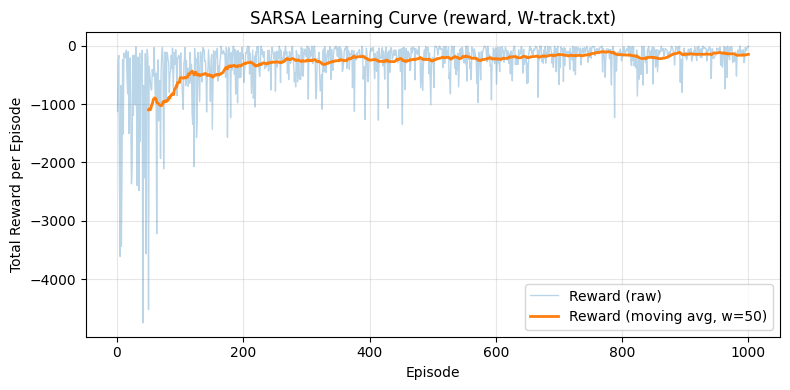

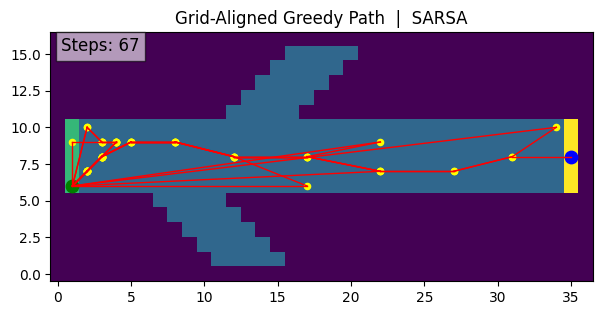

In [ ]:
from typing import List,Tuple,TypeAlias,Set, Dict
from enum import Enum, auto
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters: This line is a must. The grader parser uses this line to locate the Parameters cell.
GROUP_ID = 29
ALGORITHM = 'QLrng'  # ValItr | QLrng | SARSA.
TRACK_NAME = 'tracks/W-track.txt'
CRASH_POS = 'STRT' # NRST | STRT

FAIL_RATE = 0.2
START_IDX = 0
CRASH_SENSISTIVITY = 0.75 # How close to a corner square before it counts as a crash, 0 is standard Bresenham, but leads to slight visual corner clips

# region Definitions and Setup
Square: TypeAlias = Tuple[int, int]
Vector: TypeAlias = Tuple[int, int]

class SquareType(Enum):
    START = auto()
    FINISH = auto()
    OPEN = auto()
    WALL = auto()
    
    def __str__(self):
        return self.name

CHAR_TO_TOK = {
    'S':SquareType.START,
    'F':SquareType.FINISH,
    '.':SquareType.OPEN,
    '#':SquareType.WALL
}

TOK_TO_CHAR = {k:v for v,k in CHAR_TO_TOK.items()}

SQUARE_COST = {
    SquareType.START: 1,
    SquareType.OPEN: 1,
    SquareType.FINISH: 0,
    SquareType.WALL: None
}

def bresenham_supercover(pos1: Square, pos2: Square) -> List[Square]:
    x0, y0 = pos1
    x1, y1 = pos2

    dx = x1 - x0
    dy = y1 - y0

    sx = 1 if dx >= 0 else -1
    sy = 1 if dy >= 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    x, y = x0, y0
    points: List[Square] = [(x, y)]

    if dx == 0 and dy == 0:
        return points

    if dx >= dy:
        err = dx // 2
        while x != x1:
            err -= dy
            if err < 0:
                y += sy
                points.append((x, y))
                err += dx
            x += sx
            points.append((x, y))
    else:
        err = dy // 2
        while y != y1:
            err -= dx
            if err < 0:
                x += sx
                points.append((x, y))
                err += dy
            y += sy
            points.append((x, y))

    return points

def point_segment_distance(px, py, x1, y1, x2, y2):
    APx = px - x1
    APy = py - y1
    ABx = x2 - x1
    ABy = y2 - y1
    mag2 = ABx * ABx + ABy * ABy
    if mag2 == 0:
        return math.hypot(APx, APy)
    t = (APx * ABx + APy * ABy) / mag2
    t = max(0.0, min(1.0, t))
    cx = x1 + t * ABx
    cy = y1 + t * ABy
    return math.hypot(px - cx, py - cy)

def bresenham_line(pos1: Square, pos2: Square, width: float = CRASH_SENSISTIVITY) -> List[Square]:
    if width < 0:
        raise ValueError("width must be >= 0")

    center_line = bresenham_supercover(pos1, pos2)

    if width == 0.0:
        return center_line

    out: Set[Square] = set()

    x1, y1 = pos1[0] + 0.5, pos1[1] + 0.5
    x2, y2 = pos2[0] + 0.5, pos2[1] + 0.5

    min_x = min(p[0] for p in center_line) - math.ceil(width)
    max_x = max(p[0] for p in center_line) + math.ceil(width)
    min_y = min(p[1] for p in center_line) - math.ceil(width)
    max_y = max(p[1] for p in center_line) + math.ceil(width)

    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            cx = x + 0.5
            cy = y + 0.5
            d = point_segment_distance(cx, cy, x1, y1, x2, y2)
            if d <= width:
                out.add((x, y))

    return list(out)
# endregion

# region Track and Environment Classes
class Track:
    def __init__(self,filename=TRACK_NAME):
        self.state: List[List[SquareType]] = []
        self.start_squares: List[Square] = []
        self.finish_squares: List[Square] = []
        self.parse_track(filename)

    def parse_track(self,track):
        with open(track, 'r') as f:
            lines = f.readlines()
            for row,line in enumerate(lines[1:]):
                tok_line = []
                for col,char in enumerate(line):
                    if char=='\n': continue
                    tok = CHAR_TO_TOK[char]
                    if tok == SquareType.START: self.start_squares.append((row,col))
                    if tok == SquareType.FINISH: self.finish_squares.append((row,col))
                    tok_line.append(tok)
                self.state.append(tok_line)

    def get_square(self,square: Square) -> SquareType:
        return self.state[square[0]][square[1]]

    def get_drivable_squares(self) -> List[Square]:
        return [
            (r, c)
            for r, row in enumerate(self.state)
            for c, col in enumerate(row)
            if col != SquareType.WALL
        ]

    def get_start_squares(self) -> List[Square]:
        return self.start_squares

    def is_square_finish(self, square: Square) -> bool:
        return self.get_square(square) == SquareType.FINISH

    def is_square_drivable(self,square: Square) -> bool:
        r, c = square
        if r < 0 or r >= len(self.state): return False
        if c < 0 or c >= len(self.state[0]): return False
        return self.get_square(square) != SquareType.WALL


class RaceTrackEnv:
    def __init__(self, track: None|Track = None,starting_square: Square = None):
        self.track: Track = track or Track()
        self.position: Square = starting_square or self.track.start_squares[START_IDX]
        self.velocity: Vector = (0,0)
        self.acceleration: Vector = (0,0)

    def stop(self):
        self.acceleration = self.velocity = (0,0)

    def reset(self, position: Square):
        self.stop()
        self.position = position

    @staticmethod
    def cap_velocity(velocity: Vector) -> Vector:
        return tuple(min(5,max(-5,val)) for val in velocity)

    def do_crash(self,position: Square,crash_position: str):
        if crash_position == 'NRST':
            nearest_start = min(
                self.track.get_drivable_squares(),
                key=lambda sq: (sq[0]-position[0])**2 + (sq[1]-position[1])**2
            )
            self.reset(nearest_start)
        elif crash_position == 'STRT':
            self.reset(self.track.start_squares[START_IDX])
        else:
            raise ValueError

    def check_crash(self, start_square: Square, target_square: Square) -> Square | None:
        path_points = bresenham_line(start_square, target_square)
        crash_squares = []
        for sq in path_points:
            if not self.track.is_square_drivable(sq):
                crash_squares.append(sq)

        crash_squares.sort(
            key=lambda a: (start_square[0] - a[0])**2 + (start_square[1] - a[1])**2
        )
        
        if crash_squares: return crash_squares[0]
        else: return None

    @staticmethod
    def check_failure(fail_rate: float) -> bool:
        return random.random() < fail_rate
    
    def check_finish(self) -> bool:
        return self.track.is_square_finish(self.position)

    def step(self,acceleration: Vector,fail_rate=FAIL_RATE,crash_position=CRASH_POS):
        if not all(a in [-1,0,1] for a in acceleration):
            raise ValueError
        
        do_accel = not self.check_failure(fail_rate)
        if do_accel:
            self.acceleration = acceleration
        
        self.velocity = self.cap_velocity(
            (self.velocity[0]+self.acceleration[0],
             self.velocity[1]+self.acceleration[1])
        )
        
        target_position = (
            self.position[0]+self.velocity[0],
            self.position[1]+self.velocity[1]
        )

        crash = self.check_crash(self.position,target_position)
        if not crash:
            self.position = target_position
        else:
            self.do_crash(crash,crash_position)
# endregion

# region Model Based
State: TypeAlias = Tuple[Square,Vector]

class MDPModel:
    def __init__(self, track: Track|None = None):
        self.track = track or Track()
        self.states: Set[State] = set([
            (square, (vx, vy))
            for square in self.track.get_drivable_squares()
            for vx in range(-5, 6)
            for vy in range(-5, 6)
        ])
        self.transitions: Dict[(State, Vector):List[(State, float)]] = {
            (state,action):self.compute_transition_states_and_probs(state,action)
            for state in tqdm(self.states,desc="Computing Transitions")
            for action in self.get_possible_actions()
        }

    @staticmethod
    def cap_velocity(velocity: Vector) -> Vector:
        return tuple(min(5,max(-5,val)) for val in velocity)

    def check_crash(self, start_square: Square, target_square: Square) -> Square | None:
        path_points = bresenham_line(start_square, target_square)
        crash_squares = []
        for sq in path_points:
            if not self.track.is_square_drivable(sq):
                crash_squares.append(sq)

        crash_squares.sort(
            key=lambda a: (start_square[0] - a[0])**2 + (start_square[1] - a[1])**2
        )
        
        if crash_squares: return crash_squares[0]
        else: return None

    def do_crash(self, position: Square,crash_position: str):
        if crash_position == 'NRST':
            nearest_start = min(
                self.track.get_drivable_squares(),
                key=lambda sq: (sq[0]-position[0])**2 + (sq[1]-position[1])**2
            )
            return nearest_start
        else:
            return self.track.start_squares[START_IDX]

    @staticmethod
    def get_possible_actions() -> List[Vector]:
        return [(x,y) for x in [-1,0,1] for y in [-1,0,1]]

    def compute_transition_states_and_probs(self, state: State, action,crash_position=CRASH_POS):
        start_position,start_velocity = state

        success_velocity = self.cap_velocity(
            (start_velocity[0]+action[0], start_velocity[1]+action[1])
        )
        success_position = (
            start_position[0]+success_velocity[0],
            start_position[1]+success_velocity[1]
        )
        crash = self.check_crash(start_position, success_position)
        if crash:
            success_position = self.do_crash(crash,crash_position)
            success_velocity = (0,0)

        fail_velocity = self.cap_velocity(start_velocity)
        fail_position = (
            start_position[0] + fail_velocity[0],
            start_position[1] + fail_velocity[1],
        )
        crash = self.check_crash(start_position, fail_position)
        if crash:
            fail_position = self.do_crash(crash, crash_position)
            fail_velocity = (0, 0)

        return [
            ((fail_position,fail_velocity),FAIL_RATE),
            ((success_position,success_velocity),1-FAIL_RATE)
        ]

    def get_transition_states_and_probs(self,state:State, action:Vector):
        return self.transitions[(state,action)]

    def get_cost(self, next_state):
        return SQUARE_COST[self.track.get_square(next_state[0])]


class ValueIterationAgent:
    def __init__(self, model: MDPModel | None = None,
                 gamma: float = 0.9, theta: float = 1e-3):
        self.value_table: dict = {}
        self.policy: dict = {}
        self.model = model
        self.gamma = gamma
        self.theta = theta

        if self.model is not None:
            for s in self.model.states:
                self.value_table[s] = 0.0
            self.value_iteration()


    def value_iteration(self, max_iterations: int = 1000):
        # initialize values
        for s in self.model.states:
            self.value_table.setdefault(s, 0.0)

        prev_delta = None  # will store the first delta so we can normalize

        # tqdm bar represents convergence progress, NOT iterations
        pbar = tqdm(total=1.0, desc="Value Iteration Progress", leave=True)

        for it in range(1, max_iterations + 1):
            delta = 0.0

            for s in self.model.states:
                pos, vel = s

                if self.model.track.is_square_finish(pos):
                    new_v = 0.0
                else:
                    best_q = float("-inf")
                    for a in self.model.get_possible_actions():
                        q = 0.0
                        for next_state, prob in self.model.get_transition_states_and_probs(s, a):
                            r = -self.model.get_cost(next_state)
                            q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
                        best_q = max(best_q, q)

                    new_v = best_q

                old_v = self.value_table.get(s, 0.0)
                delta = max(delta, abs(new_v - old_v))
                self.value_table[s] = new_v

            if prev_delta is None:
                prev_delta = delta if delta > 1e-12 else 1.0

            # Compute progress toward convergence
            progress = max(0.0, min(1.0, 1 - delta / prev_delta))

            # Update progress bar fill
            pbar.n = progress
            pbar.set_description(f"Iter {it} | Δ={delta:.3f} | Progress={progress*100:.2f}%")
            pbar.refresh()

            if delta < self.theta:
                break

        pbar.close()
        self._extract_policy()


    def _extract_policy(self):
        assert self.model is not None
        self.policy.clear()
        for s in self.model.states:
            pos, vel = s
            if self.model.track.is_square_finish(pos):
                continue
            actions = self.model.get_possible_actions()

            best_a = None
            best_q = float("-inf")
            for a in actions:
                q = 0.0
                for next_state, prob in self.model.get_transition_states_and_probs(s, a):
                    r = -self.model.get_cost(next_state)
                    q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
                if q > best_q:
                    best_q = q
                    best_a = a
            self.policy[s] = best_a

    def get_action_for(self, state):
        if state in self.policy:
            return self.policy[state]
        return None

    def extract_greedy_path(self, max_steps: int = 1000) -> List[Square]:
        start_square = self.model.track.start_squares[START_IDX]
        state: State = (start_square, (0, 0))
        path: List[Square] = [start_square]

        for _ in range(max_steps):
            pos, vel = state
            if self.model.track.is_square_finish(pos):
                break

            action = self.get_action_for(state)
            transitions = self.model.get_transition_states_and_probs(state, action)
            next_state,_ = max(transitions, key=lambda item: item[1])

            state = next_state
            path.append(state[0])

        return path

# endregion

# region SARSA + QLearning
class SARSAAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=1.0,
                 epsilon_min=0.05, epsilon_decay=0.995):
        self.qtable = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.actions = MDPModel.get_possible_actions()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def _q_value(self, state, action):
        return self.qtable.get((state, action), 0.0)

    def best_action(self, state):
        best_q = float("-inf")
        best_actions = []
        for a in self.actions:
            q = self._q_value(state, a)
            if q > best_q:
                best_q = q
                best_actions = [a]
            elif q == best_q:
                best_actions.append(a)
        return random.choice(best_actions)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return self.best_action(state)

    def update(self, state, action, reward, next_state, next_action, done=False):
        old_q = self.qtable.get((state, action), 0.0)
        if done or next_state is None or next_action is None:
            target = reward
        else:
            target = reward + self.gamma * self._q_value(next_state, next_action)
        self.qtable[(state, action)] = old_q + self.alpha * (target - old_q)


class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9,
                 epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.qtable = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.actions = MDPModel.get_possible_actions()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def _q_value(self, state, action):
        return self.qtable.get((state, action), 0.0)

    def best_action(self, state):
        best_q = float("-inf")
        best_actions = []
        for a in self.actions:
            q = self._q_value(state, a)
            if q > best_q:
                best_q = q
                best_actions = [a]
            elif q == best_q:
                best_actions.append(a)
        return random.choice(best_actions)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        return self.best_action(state)

    def update(self, state, action, reward, next_state, done=False):
        old_q = self.qtable.get((state, action), 0.0)
        if done or next_state is None:
            target = reward
        else:
            max_next = max(self._q_value(next_state, a) for a in self.actions)
            target = reward + self.gamma * max_next
        self.qtable[(state, action)] = old_q + self.alpha * (target - old_q)
# endregion

# region Output and Metrics
class EpisodeRunner:
    def __init__(self, env: RaceTrackEnv, agent, max_steps: int = 1000):
        self.env = env
        self.agent = agent
        self.max_steps = max_steps

    def _current_state(self) -> State:
        return (self.env.position, self.env.velocity)

    def _reward(self) -> float:
        square_type = self.env.track.get_square(self.env.position)
        cost = SQUARE_COST[square_type]
        return -float(cost)

    def run_episode(self, start_square: Square | None = None):
        if start_square is None:
            start_square = self.env.track.start_squares[START_IDX]
        self.env.reset(start_square)

        total_reward = 0.0
        steps = 0
        crashes = 0

        if isinstance(self.agent, SARSAAgent):
            state = self._current_state()
            action = self.agent.act(state)

            for _ in range(self.max_steps):
                prev_pos = self.env.position
                self.env.step(action)
                if self.env.position == prev_pos and not self.env.track.is_square_finish(self.env.position):
                    crashes += 1

                reward = self._reward()
                total_reward += reward
                steps += 1

                next_state = self._current_state()
                done = self.env.track.is_square_finish(self.env.position)

                if done:
                    self.agent.update(state, action, reward, None, None, done=True)
                    break

                next_action = self.agent.act(next_state)
                self.agent.update(state, action, reward, next_state, next_action, done=False)

                state = next_state
                action = next_action

        else:
            for _ in range(self.max_steps):
                state = self._current_state()
                action = self.agent.act(state)

                prev_pos = self.env.position
                self.env.step(action)
                if self.env.position == prev_pos and not self.env.track.is_square_finish(self.env.position):
                    crashes += 1

                reward = self._reward()
                total_reward += reward
                steps += 1

                next_state = self._current_state()
                done = self.env.track.is_square_finish(self.env.position)

                self.agent.update(state, action, reward, None if done else next_state, done=done)

                if done:
                    break

        return steps, total_reward, crashes


class MetricsLogger:
    def __init__(self):
        self.episodes = []
        self.steps = []
        self.rewards = []
        self.crashes = []
        self.successes = 0

    def log_episode(self, episode, steps, reward, crashes, finished):
        self.episodes.append(episode)
        self.steps.append(steps)
        self.rewards.append(reward)
        self.crashes.append(crashes)
        if finished:
            self.successes += 1

    def print_metrics(self):
        if not self.episodes:
            print("No episodes logged.")
            return

        n = len(self.episodes)
        avg_steps = sum(self.steps) / n
        avg_reward = sum(self.rewards) / n
        avg_crashes = sum(self.crashes) / n

        print(f"Episodes logged: {n}")
        print(f"Success rate: {self.successes}/{n}")
        print(f"Steps per episode: mean = {avg_steps:.2f}, min = {min(self.steps)}, max = {max(self.steps)}")
        print(f"Reward per episode: mean = {avg_reward:.2f}, min = {min(self.rewards):.2f}, max = {max(self.rewards):.2f}")
        print(f"Crashes per episode: mean = {avg_crashes:.2f}, min = {min(self.crashes)}, max = {max(self.crashes)}")

    def write_summary(self, filename: str):
        with open(filename, "w") as f:
            n = len(self.episodes)
            avg_steps = sum(self.steps) / n
            avg_reward = sum(self.rewards) / n
            avg_crashes = sum(self.crashes) / n

            f.write(f"Episodes logged: {n}\n")
            f.write(f"Success rate: {self.successes}/{n}\n")
            f.write(f"Avg steps: {avg_steps:.2f}\n")
            f.write(f"Min steps: {min(self.steps)}\n")
            f.write(f"Max steps: {max(self.steps)}\n")
            f.write(f"Avg reward: {avg_reward:.2f}\n")
            f.write(f"Min reward: {min(self.rewards):.2f}\n")
            f.write(f"Max reward: {max(self.rewards):.2f}\n")
            f.write(f"Avg crashes: {avg_crashes:.2f}\n")
            f.write(f"Min crashes: {min(self.crashes)}\n")
            f.write(f"Max crashes: {max(self.crashes)}\n")

    def plot_path(self, track: Track, path: List[Square]):
        n_rows = len(track.state)
        n_cols = len(track.state[0])
        grid = np.zeros((n_rows, n_cols))
        for r, row in enumerate(track.state):
            for c, cell in enumerate(row):
                grid[r, c] = {SquareType.WALL: 0, SquareType.OPEN: 1,
                            SquareType.START: 2, SquareType.FINISH: 3}[cell]

        steps = len(path) - 1

        plt.figure(figsize=(7, 7))
        plt.imshow(grid, origin="upper")

        # draw lines
        for (r1, c1), (r2, c2) in zip(path[:-1], path[1:]):
            plt.plot([c1, c2], [r1, r2], color="red", linewidth=1)

        # draw points
        (sr, sc) = path[0]
        (er, ec) = path[-1]
        for (r, c) in path:
            plt.scatter([c], [r], s=20, color="yellow")
        plt.scatter([sc], [sr], s=80, color="green", label="Start")
        plt.scatter([ec], [er], s=80, color="blue", label="End")

        plt.gca().invert_yaxis()

        plt.title(f"Grid-Aligned Greedy Path  |  {ALGORITHM}")

        # TEXT BOX ON THE PLOT
        plt.text(
            0.02, 0.98,
            f"Steps: {steps}",
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="black")
        )

        plt.savefig(f"{GROUP_ID}_{ALGORITHM}_{TRACK_NAME.split('/')[-1]}_{CRASH_POS}.png")
        plt.show()

    def plot_learning_curve(self, metric: str = "reward", window: int = 50):
        """
        Plot a learning curve for a model-free method.
        metric: "reward", "steps", or "crashes"
        window: moving-average window size
        """
        if not self.episodes:
            print("No episodes logged, cannot plot learning curve.")
            return

        if metric == "reward":
            values = self.rewards
            ylabel = "Total Reward per Episode"
        elif metric == "steps":
            values = self.steps
            ylabel = "Steps per Episode"
        elif metric == "crashes":
            values = self.crashes
            ylabel = "Crashes per Episode"
        else:
            raise ValueError(f"Unknown metric '{metric}'. Use 'reward', 'steps', or 'crashes'.")

        episodes = np.array(self.episodes, dtype=float)
        values = np.array(values, dtype=float)

        # Moving average smoothing
        if len(values) >= window:
            kernel = np.ones(window) / window
            smooth_values = np.convolve(values, kernel, mode="valid")
            smooth_episodes = episodes[window - 1:]
        else:
            # Not enough data for a full window; just plot raw values
            smooth_values = values
            smooth_episodes = episodes

        plt.figure(figsize=(8, 4))

        # Optional: plot raw values lightly in background
        plt.plot(episodes, values, alpha=0.3, linewidth=1, label=f"{metric.capitalize()} (raw)")

        # Smoothed curve
        plt.plot(smooth_episodes, smooth_values, linewidth=2, label=f"{metric.capitalize()} (moving avg, w={window})")

        plt.xlabel("Episode")
        plt.ylabel(ylabel)
        plt.title(f"{ALGORITHM} Learning Curve ({metric}, {TRACK_NAME.split('/')[-1]})")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{GROUP_ID}_{ALGORITHM}_{TRACK_NAME.split('/')[-1]}_{CRASH_POS}_learning_curve.png")
        plt.show()

# endregion

def main():
    print("Reinfocement Learning Racecar ", ALGORITHM)
    track = Track(TRACK_NAME)
    n_episodes = 1000
    OUTPUT_METRICS = False
    LEARNING_CURVE = True

    if ALGORITHM == 'ValItr':
        model = MDPModel(track)
        agent = ValueIterationAgent(model=model, gamma=0.9, theta=1e-3)

        logger = MetricsLogger()
        best_path = agent.extract_greedy_path()
        logger.plot_path(track, best_path)

    elif ALGORITHM == 'QLrng':
        env = RaceTrackEnv(track)
        agent = QLearningAgent(alpha=0.1, gamma=0.95, epsilon=0.1)
        runner = EpisodeRunner(env, agent, max_steps=1_000)
        logger = MetricsLogger()

        for ep in tqdm(range(1, n_episodes + 1), desc="Episodes"):
            steps, total_reward, crashes = runner.run_episode()
            finished = env.track.is_square_finish(env.position)
            logger.log_episode(ep, steps, total_reward, crashes, finished)
            agent.decay_epsilon()

        summary_name = f"{GROUP_ID}_{ALGORITHM}_{TRACK_NAME.split('/')[-1]}_{CRASH_POS}_metrics.txt"
        if OUTPUT_METRICS:
            logger.write_summary(summary_name)
            print(f"Wrote summary to {summary_name}")
            logger.print_metrics()
        
        if LEARNING_CURVE:
            logger.plot_learning_curve()

        path = []
        env.reset(track.start_squares[START_IDX])
        for _ in range(1000):
            pos = env.position
            path.append(pos)
            if track.is_square_finish(pos): break
            state = (env.position, env.velocity)
            action = agent.best_action(state)
            env.step(action)

        logger.plot_path(track, path)

    elif ALGORITHM == 'SARSA':
        env = RaceTrackEnv(track)
        agent = SARSAAgent(alpha=0.1, gamma=0.975, epsilon=0.1)
        runner = EpisodeRunner(env, agent, max_steps=10_000)
        logger = MetricsLogger()

        for ep in tqdm(range(1, n_episodes + 1), desc="Episodes"):
            steps, total_reward, crashes = runner.run_episode()
            finished = env.track.is_square_finish(env.position)
            logger.log_episode(ep, steps, total_reward, crashes, finished)
            agent.decay_epsilon()

        if OUTPUT_METRICS:
            summary_name = f"{GROUP_ID}_{ALGORITHM}_{TRACK_NAME.split('/')[-1]}_{CRASH_POS}_metrics.txt"
            logger.write_summary(summary_name)
            print(f"Wrote summary to {summary_name}")
            logger.print_metrics()

        if LEARNING_CURVE:
            logger.plot_learning_curve()

        path = []
        env.reset(track.start_squares[START_IDX])
        for _ in range(1000):
            pos = env.position
            path.append(pos)
            if track.is_square_finish(pos): break
            state = (env.position, env.velocity)
            action = agent.best_action(state)
            env.step(action)

        logger.plot_path(track, path)

    else:
        raise ValueError(f"Unknown ALGORITHM: {ALGORITHM}")

if __name__ == "__main__":
    main()


